In [2]:
%load_ext autoreload
%autoreload 2

# Analysis of Lyrics from Historical Billboard Top 100 Singles
### Kenta Burpee, James Jagielski, Satchel Sevenau

## Introduction
Throughout the decades, popular music has changed significantly. Artists have gained and lost popularity, and genres have risen and fallen. However, one thing that remains relatively constant is that popular songs tend to contain catchy, repetitive phrases, often repeating the song title in them. 

This leads to the central question of our project: among the Billboard top 100 singles of the last five decades, what are the trends that can be seen in how often a song title is mentioned in its lyrics? Through answering this question, we aim to illustrate how the frequency of song titles mentioned in lyrics have changed over the years, find the distribution of title-in-lyrics frequencies for the data set, and find top songs and artists who repeat titles in their lyrics the most.

Gathering and analyzing this information requires four major steps. First, collecting a list of historical Billboard top 100 songs from Wikipedia. Second, going through that list and finding lyrics for each song from Genius. Third, taking this information to find the number of times the title is mentioned in the lyrics for each song and converting it to a list containing information for each song. Finally, graphing the data in different ways to analyze its patterns.



## Methodology
### The Songs
To answer our central question we need two critical pieces of data: the songs in the Billboard top 100 for a range of years and the lyrics of each song. We decided to use Wikipedia to get a list of top songs because they had a page called “Billboard Year-End Top 100 Singles of (year)” for each year and an accessible API we could use to scrape the HTML of each page.

The code below imports functions from the file wiki_data.py that scrape song data from Wikipedia and write it to a CSV file. The function get_all_top_songs takes two arguments that represent a range of years to get a list of top 100 songs from. In our case, we want the last 52 years, so our inputs are 1970 to 2021, which returns a list of 5200 songs, where each song is a list in the form [Title, Artist, Year, Rank]. "Baby" by Justin Bieber was number 44 in 2010, so the list for that song would be [Baby, Justin Bieber, 2010, 44]. In order to get this list of songs, the function accesses the Wikipedia page for each year using the wikipedia package and parses the HTML for the title, artist, and rank of each song. In some special cases, artist names are replaced with alternates (e.g. Tupac Shakur to 2Pac or Sean Combs to Diddy) in order to make accessing the lyrics later on easier.

The function write_songs_to_file takes the list generated by get_all_top_songs and stores the information into a CSV file called songs.csv.

#### WARNING: Running the code cell below will take 3-5 minutes. The output will be the same as the data currently in songs.csv.

In [ ]:
import wiki_data
song_list_all_years = wiki_data.get_all_top_songs(1970, 2021)
wiki_data.write_songs_to_file(song_list_all_years)

The following is a taste of the information stored in songs.csv generated by wiki_data.py:

In [3]:
with open("songs.csv", newline="") as my_file:
    for _ in range(10):
        line = my_file.readline()
        print(line)

Title,Artist,Year,Rank

Bridge Over Troubled Water,Simon & Garfunkel,1970,1

(They Long to Be) Close to You,The Carpenters,1970,2

American Woman,The Guess Who,1970,3

Raindrops Keep Fallin' on My Head,B.J. Thomas,1970,4

War,Edwin Starr,1970,5

Ain't No Mountain High Enough,Diana Ross,1970,6

I'll Be There,The Jackson 5,1970,7

Get Ready,Rare Earth,1970,8

Let It Be,The Beatles,1970,9



### The Lyrics

Now that we have a list of songs, we need to get the lyrics for each song. We achieved this by accessing genius.com for lyrics, using the requests library to get the HTML and the BeautifulSoup library to parse it for the lyrics. In order to access the lyrics for each song, we needed to format each song in a way that could be turned into a Genius URL. The first step in this process was to convert songs.csv (which contains information scraped from Wikipedia) into a list of lists containing song information. Then, we called the function format_list_for_genius to format the title and artist in a way that could be pasted into a URL. This involved removing special characters, punctuation, and capitalization, as well as replacing hyphens with spaces. 

Below is a sample list containing information for two songs and the formatted output for the songs.

In [4]:
from genius import format_list_for_genius

sample_list = [["Whatcha Say", "Jason Derulo", "2010", "43"], ["Baby", "Justin Bieber", "2010", "44"]]
jason_justin_formatted = format_list_for_genius(sample_list)
print(jason_justin_formatted)

[['whatcha-say', 'jason-derulo'], ['baby', 'justin-bieber']]


The get_lyrics function then retrieves the lyrics for a particular song given a list containing the formatted title and artist. Since all Genius lyrics URLs are in the form "genius.com/ + ARTIST- + TITLE- + lyrics", these formatted lists ensured that we were accessing the correct pages. Below is an example of lyrics retrieved for Baby by Justin Bieber, formatted into a Genius-URL-friendly list above.

In [5]:
from genius import get_lyrics
justin_lyrics = get_lyrics(jason_justin_formatted[1])
print(justin_lyrics[0:501] + "...\n")

ConnectionError: HTTPSConnectionPool(host='genius.com', port=443): Max retries exceeded with url: /justin-bieber-baby-lyrics (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7fac147bf400>: Failed to establish a new connection: [Errno -3] Temporary failure in name resolution'))


The function write_lyrics_to_file from genius.py does all of this for all 5200 songs. It calls helper functions to convert songs.csv into a list, converts the list to a URL-friendly format, retrieves lyrics for all songs, and finally writes all of this data into a CSV file called songs_with_lyrics.csv.

#### WARNING: Running the code cell below may take 2-3 **hours**. The output will be the same as the data currently in songs_with_lyrics.csv

In [ ]:
from genius import write_lyrics_to_file
write_lyrics_to_file()

After saving the lyrics in songs_with_lyrics.csv, we realized that the lyrics for some of the songs were missing. Upon further investigation, we found that this was caused by a discrepency between how songs were listed in Wikipedia and in Genius. For instance, Wikipedia says that the song "Get Low" is by Lil Jon, but Genius says that the artist is "Lil Jon & the East Side Boyz". Therefore, we were not able to retrieve those lyrics because we had the wrong URL.

The code cell below calculates the percentage of the 5200 songs we are missing lyrics for. We decided that the number was low enough that it did not cause any significant changes in trends we saw in our data.

In [9]:
import finder
song_list_by_song = finder.get_total_song_data("songs_with_lyrics.csv", by_song=True)
count = 0
for song in song_list_by_song:
    if song[4] == -1:
        count += 1
print("Missing lyrics for " + str(round(count/52, 2)) + "% of the total songs")

Missing lyrics for 3.79% of the total songs


### The Analysis
The last thing we needed before graphing our data was to get the frequency of each song's title within its lyrics. We did this by simply taking the title formatted to lower case and counting how many times it appears within the lyrics formatted to lower case. If the song was one of the songs we weren't able to retrieve lyrics for, we set its title frequency to -1. The function below copied from finder.py does this process for one song. The song argument is a list containing [Title, Artist, Year, Rank, Lyrics], and the function returns a number representing the number of times the title appears in the lyrics.

In [6]:
def title_in_lyrics_one_song(song):
    title = song[0]
    lyrics = song[4]
    if '(' in title:
        title = title[0:title.find("(") - 1]
    if len(lyrics) == 0:
        return -1
    return lyrics.lower().count(title.lower())

The function get_total_song_data, also from finder.py, goes through this process for all 5200 songs and returns a list of lists containing the title, artist, year, rank, and frequency of the title in the lyrics for each song. The argument by_song determines whether each list within the outer list represents a song (by_song=True) or a category of data (by_song=False). 

In [11]:
from genius import csv_to_list
def get_total_song_data(path, by_song=False):
    total_song_data = []
    song_list = csv_to_list(path)
    if by_song:
        for song in song_list:
            total_song_data.append([song[0], song[1], song[2], song[3], title_in_lyrics_one_song(song)])
    else:
        titles = []
        artists = []
        years = []
        ranks = []
        frequencies = []
        for song in song_list:
            titles.append(song[0])
            artists.append(song[1])
            years.append(song[2])
            ranks.append(song[3])
            frequencies.append(title_in_lyrics_one_song(song))
        total_song_data = [titles, artists, years, ranks, frequencies]

    return total_song_data

This function is used to graph and analyze our data in the results section of this essay.

## Results
To visualize our data, we utilized multiple types of graphs, charts and lists to represent our collected results. Below, we have created visualizations for multiple relationships, such as: average frequency (number of times), title is mentioned in the lyrics by the ranking of the song, average frequency the title is mentioned in the lyrics by year and by decade, compared all the number one ranked songs and how many times they mention their title in the lyrics, compared the largest number of mentions from each year, and what percent of songs mention their title within the lyrics. Using lists, we also visualize 20 largest number of mentions, and top ten artists who mention the title within the lyrics the most(on average) and have appeared within the top 100 more than once.

In [14]:
import finder
import matplotlib.pyplot as plt
song_list = finder.get_total_song_data("songs_with_lyrics.csv") #[Title, Artist, Year, Rank, Frequency]
titles = song_list[0]
artists = song_list[1]
possible_rankings = list(range(1, 101))
possible_years = list(range(1970, 2022))
frequencies = song_list[4]

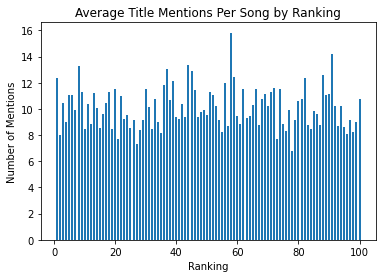

In [19]:
average_frequencies = []
for i in range(100):
    total_mentions = 0
    for j in range(i, 5200, 100):
        if frequencies[j] != -1:
            total_mentions += frequencies[j]
    average_frequencies.append(round(total_mentions/52, 2))
    
plt.bar(possible_rankings, average_frequencies, width=0.655)
plt.title("Average Title Mentions Per Song by Ranking")
plt.xlabel("Ranking")
plt.ylabel("Number of Mentions");

The visual, Average Title Mentions Per Song by Ranking, shows that there is no trend between rank and number of times title is mentioned in lyrics.

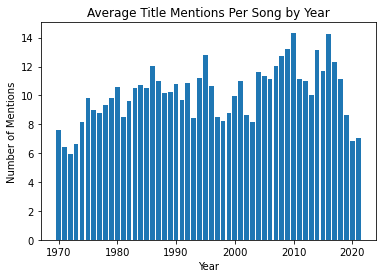

In [37]:
frequency_by_year = []
for i in range(0, 5200, 100):
    mention_count = 0
    for j in range(i, i+ 100):
        if frequencies[j] != -1:
            mention_count += frequencies[j]
    frequency_by_year.append(round(mention_count/100, 2))

plt.bar(possible_years, frequency_by_year)
plt.title("Average Title Mentions Per Song by Year")
plt.xlabel("Year")
plt.ylabel("Number of Mentions");

The average mentions by year graph shows that there is an increasing trend of mentions per year. This means on average the songs in the 2000s have more mentions than the songs in the late 1900s. The number of mentions increases from 6-8 in the 1970s to 14 in the 2010s. While this trend is harder to visualize by each year, it becomes much more apparent by decade.

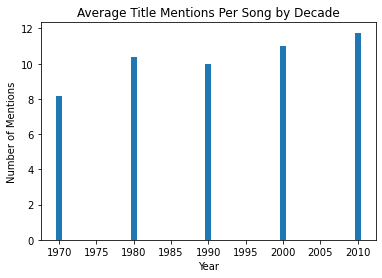

In [39]:
frequency_by_decade = []
for i in range(5):
    frequency_by_decade.append(round(sum(frequency_by_year[10*i:10*i + 10])/10, 2))

possible_decades = list(range(1970, 2020, 10))
plt.bar(possible_decades, frequency_by_decade)
plt.title("Average Title Mentions Per Song by Decade")
plt.xlabel("Year")
plt.ylabel("Number of Mentions");

When we shift the average mentions to decades instead of years the increasing trend becomes much clearer. There is an increase in the average number of mentions over time.

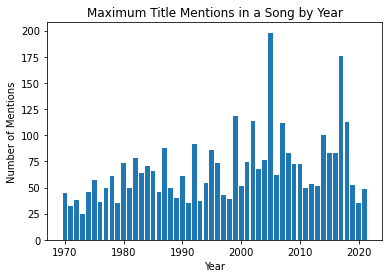

In [43]:
maximum_song_frequency_by_year = []
for i in range(52):
    maximum_song_frequency_by_year.append(max(frequencies[100*i: 100*i + 100]))
    
plt.bar(possible_years, maximum_song_frequency_by_year)
plt.title("Maximum Title Mentions in a Song by Year")
plt.xlabel("Year")
plt.ylabel("Number of Mentions");

This graph shows the highest number of mentions for each year; again there's an overall increase in the number of mentions over time. It's key to note that earlier years are pretty consistent in the maximum number of mentions, meaning the maximum mention of one year stays close to the maximum mention of the previous year (around 50 mentions). Whereas, in the 2000's-2020's, the number of mentions oscilates much more. Having max mentions way above 100, but also having max mentions as low as 50. 

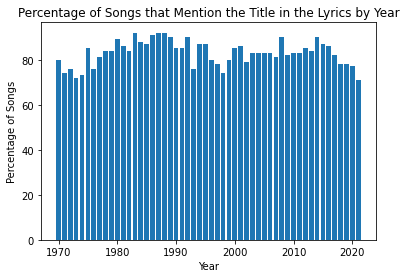

In [24]:
percent_mentions_by_year = []
for i in range(52):
    number_mentioned_in_year = 0
    for j in range(100):
        if frequencies[100*i+j] > 0:
            number_mentioned_in_year += 1
    percent_mentions_by_year.append(number_mentioned_in_year)

plt.bar(possible_years, percent_mentions_by_year)
plt.title("Percentage of Songs that Mention the Title in the Lyrics by Year")
plt.xlabel("Year")
plt.ylabel("Percentage of Songs");

The percent of songs each year that mentions their song title, is relatively consistent, at about 80% of the songs mentioning their title within the lyrcis. 

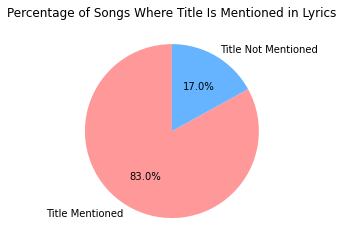

In [25]:
total_mentions_all_years = sum(percent_mentions_by_year)
pie_elements = [total_mentions_all_years, 5200 - total_mentions_all_years]
colors = ["#ff9999", "#66b3ff"]
labels = {"Title Mentioned", "Title Not Mentioned"}
plt.pie(pie_elements, labels=labels, colors=colors, autopct="%1.1f%%", startangle = 90)
plt.title("Percentage of Songs Where Title Is Mentioned in Lyrics");

In [21]:
from better_profanity import profanity
freq_temp = frequencies.copy()
print("Top twenty songs where the title is mentioned the most:\n")
previous_title = None
count = 0
while count < 20:
    mfi = freq_temp.index(max(freq_temp))
    if titles[mfi] != previous_title:
        print(f"{count + 1}. \"{profanity.censor(titles[mfi])}\" by {artists[mfi]} ({max(freq_temp)} mentions)")
        count += 1
    previous_title = titles[mfi]
    freq_temp[mfi] = 0

Top twenty songs where the title is mentioned the most:

1. "O" by Omarion (198 mentions)
2. "Down" by Marian Hill (176 mentions)
3. "Who Dat" by JT Money (118 mentions)
4. "Baby" by Ashanti (114 mentions)
5. "Thunder" by Imagine Dragons (113 mentions)
6. "Walk It Out" by Unk (112 mentions)
7. "My ****" by YG (100 mentions)
8. "Jump" by Kris Kross (92 mentions)
9. "Bad" by Michael Jackson (88 mentions)
10. "Baby" by Brandy Norwood (86 mentions)
11. "Say" by John Mayer (83 mentions)
12. "Watch Me (Whip/Nae Nae)" by Silentó (83 mentions)
13. "Work" by Rihanna (80 mentions)
14. "Get Down on It" by Kool & the Gang (78 mentions)
15. "Taste" by Tyga (77 mentions)
16. "Why" by Jadakiss (76 mentions)
17. "No" by Meghan Trainor (75 mentions)
18. "Stutter" by Joe (74 mentions)
19. "Call Me" by Blondie (73 mentions)
20. "Doin' It" by LL Cool J (73 mentions)


In [20]:
artists_and_mentions = {}
for i in range(5200):
    if artists[i] not in artists_and_mentions:
        artists_and_mentions[artists[i]] = [frequencies[i], 1]
    else:
        artists_and_mentions[artists[i]][0] += frequencies[i]
        artists_and_mentions[artists[i]][1] += 1
for musician in artists_and_mentions:
    artists_and_mentions[musician].append(round(artists_and_mentions[musician][0]/artists_and_mentions[musician][1], 2))
    
a_and_m = artists_and_mentions.copy()
print("Top ten artists who mention the title in the lyrics on average the most")
print("(and have appeared in the top 100 more than once):\n")
for i in range(10):
    max_number = None
    max_artist = None
    for musician in a_and_m:
        if max_number is None or a_and_m[musician][2]  > max_number and a_and_m[musician][1] > 1:
            max_artist = musician
            max_number = a_and_m[musician][2]
    print(f"{i+1}. {max_artist} ({max_number} mentions)")
    a_and_m[max_artist][2] = 0

Top ten artists who mention the title in the lyrics on average the most
(and have appeared in the top 100 more than once):

1. Silentó (83.0 mentions)
2. Omarion (66.33 mentions)
3. Tyga (65.0 mentions)
4. YG (58.5 mentions)
5. Unk (57.5 mentions)
6. Jay Sean (55.67 mentions)
7. O.T. Genasis (48.0 mentions)
8. D'Angelo (45.0 mentions)
9. Ella Mai (43.67 mentions)
10. Los del Río (43.0 mentions)


In [1]:
frequency_list = []
possible_frequencies = list(range(max(frequencies)))
for i in range(max(frequencies)):
    frequency_list.append(frequencies.count(i))
plt.bar(possible_frequencies, frequency_list)
plt.title("Number of Songs that Mention their Title Within their Lyrics for Different Frequencies")
plt.xlabel("Frequency")
plt.ylabel("Number of Songs");

NameError: name 'frequencies' is not defined

<BarContainer object of 50 artists>

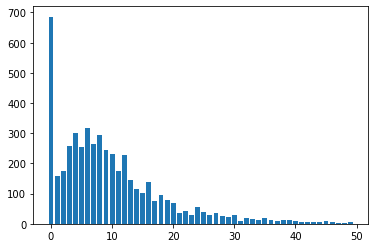

In [17]:
plt.bar(possible_frequencies[0:50], frequency_list[0:50])
plt.title("Number of Songs that Mention their Title Within their Lyrics for Different Frequencies")
plt.xlabel("Frequency")
plt.ylabel("Number of Songs");

Based on our analysis of the data we have concluded a few main takeaways. First, the number of times a title is mentioned within a songs lyrics has grown on average. Second, the number of songs that mention the title stays constant each year; at around 80-85% of the songs mentioning the title within their lyrics. Another interesting aspect of the data is a large majority of songs, that menton their title within the lyrcis, are from the 2000s. We can conclude that the songs in the 2000s increased the frequency at which the titles appear in the songs, but didn't increase the amount of songs that included the title. Thus, the number of overall mentions increases.

## Conclusion


The important insights that readers should get is how to scrape data that is desirable for their needs. For our project, we needed data to tell a story and create visuals for song data. With this project readers will be able to scrape a songs title, lyrics, and ranking within the top 100 and see examples on how to filter and visulaize results. This also gets into the ethical issues of data scraping, while our specific project has low to no ethical implications, the ability of data scrapping can cause great harm. Due to it's easy access, a lot of data can be easily used. Some people might have poor intentions with it and others may accidentally use it poorly. There is a lot of personal data available that people put online. For example, if someone has your unique four digit "key", they could scrap every single one of your discord conversations. We learned that collecting data isn't as straight forward as it sounds, and some websites are very hard to access. Once we found those websites that offered easy access, the rest of the process was relativley simple. The most frustrating parts of this project was formating the "key words" we needed for the data, into a form that was compatible with our desired websites. For example reformating the title and artist data into a link that was compatible with the Genius website format. There are a few ways we can extend this project. We can take the data we already have and try to use it to predict what the title of the song is based on the lyrics. We can also try to see the number of mentions based on genre of music. Finally, we can try to find what other conditions influence a songs rankings in the top 100.